In [1]:
# see: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
cpu='0'
os.environ['CUDA_VISIBLE_DEVICES']=cpu

from bio_learn2 import *

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model_cnn = '../data/0020_SimpleConvClassifier.pkl'
pretrained_model_bio = '../data/0020_BioClassifier.pkl'

In [3]:
model_cnn = torch.load(pretrained_model_cnn).eval()
model_bio = torch.load(pretrained_model_bio).eval()

In [4]:
test_X, test_y = get_data('test')
test_ds = TensorDataset(test_X, test_y)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

In [5]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [6]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item(): continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [7]:
def test_attack(model):
    accuracies = []
    examples = []

    for eps in epsilons:
        acc, ex = test(model, 'cuda', test_dl, eps)
        accuracies.append(acc)
        examples.append(ex)
    return accuracies, examples

In [8]:
print('\n\nTesting a Simple Convolutional NN')
accuracies_cnn, examples_cnn = test_attack(model_cnn)
print('\n\nTesting a Bio Classifier')
accuracies_bio, examples_bio = test_attack(model_bio)



Testing a Simple Convolutional NN
Epsilon: 0	Test Accuracy = 9782 / 10000 = 0.9782
Epsilon: 0.05	Test Accuracy = 9275 / 10000 = 0.9275
Epsilon: 0.1	Test Accuracy = 8082 / 10000 = 0.8082
Epsilon: 0.15	Test Accuracy = 6105 / 10000 = 0.6105
Epsilon: 0.2	Test Accuracy = 3591 / 10000 = 0.3591
Epsilon: 0.25	Test Accuracy = 1550 / 10000 = 0.155
Epsilon: 0.3	Test Accuracy = 566 / 10000 = 0.0566


Testing a Bio Classifier
Epsilon: 0	Test Accuracy = 9664 / 10000 = 0.9664
Epsilon: 0.05	Test Accuracy = 7178 / 10000 = 0.7178
Epsilon: 0.1	Test Accuracy = 3214 / 10000 = 0.3214
Epsilon: 0.15	Test Accuracy = 2622 / 10000 = 0.2622
Epsilon: 0.2	Test Accuracy = 2609 / 10000 = 0.2609
Epsilon: 0.25	Test Accuracy = 2609 / 10000 = 0.2609
Epsilon: 0.3	Test Accuracy = 2609 / 10000 = 0.2609


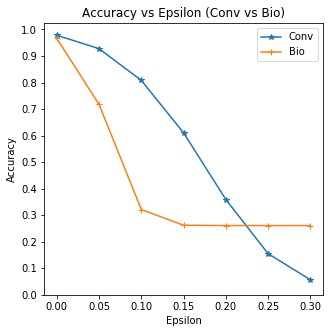

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_cnn, "*-", label='Conv')
plt.plot(epsilons, accuracies_bio, "+-", label='Bio')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Conv vs Bio)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.show()